In [1]:
from ssri_interactions.interactions.loaders import SpontaneousActivityLoader
from ssri_interactions.interactions.preprocessors import InteractionsPreprocessor
from ssri_interactions.interactions.pairwise import PairwiseCorr
from ssri_interactions.transforms.spikes import SpikesHandler
from ssri_interactions.io import load_derived_generic
from ssri_interactions.config import Config

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

c:\ProgramData\Miniconda3\envs\ssri\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
sns.set_theme(style="ticks", context="paper")
fig_dir = Config.fig_dir / "spont interactions"
fig_dir.mkdir(exist_ok=True, parents=True)

In [3]:
def reorder_df_affinity(df, ensemble_labels):
    idx = np.argsort(ensemble_labels)
    return df.iloc[idx, idx]

def reorder_spikes(df, ensemble_labels):
    idx = np.argsort(ensemble_labels)
    return df.iloc[idx, :]


def get_affinity(session_name, t_start=0, t_stop=1800, rectify=True):
    loader = SpontaneousActivityLoader(session_name=session_name, t_start=t_start, t_stop=t_stop)
    preprocessor = InteractionsPreprocessor(z=True)
    mod = PairwiseCorr(rectify=rectify)

    spikes = preprocessor(loader())
    return mod.fit(spikes).get_adjacency_df()

def plot_affinity(df_affinity, ax, vmax=None, **kwargs):
    sns.heatmap(df_affinity, cmap="viridis", vmin=0, vmax=vmax, robust=True, ax=ax, **kwargs)
    return ax

def plot_spikes(spikes, ax, vmax=None, **kwargs):
    sns.heatmap(spikes, cmap="Greys", vmin=0, vmax=vmax, robust=True, ax=ax, **kwargs)
    return ax

def plot_lineplot(spikes, neurons, ax=None, sigma=None, colors=("red", "grey"), **kwargs):
    spikes = spikes.loc[neurons, :]
    if sigma is not None:        
        spikes = spikes.transform(gaussian_filter1d, sigma=sigma, axis=1)
    time = spikes.columns.values
    n1 = spikes.loc[neurons[0], :].values
    n2 = spikes.loc[neurons[1], :].values
    ax.plot(time, n1, label=neurons[0], color=colors[0], **kwargs)
    ax.plot(time, n2, label=neurons[1], color=colors[1], **kwargs)
    return ax

In [4]:
neuron_types = (
    load_derived_generic("neuron_types.csv")
    .query("group in ('SAL', 'CIT')")
)
sal_sessions = (
    neuron_types
    .query("group == 'SAL'")
    .session_name
    .unique()
)
cit_sessions = (
    neuron_types
    .query("group == 'CIT'")
    ["session_name"]
    .unique()
)
print(f"SAL sessions:\n{sal_sessions.tolist()}")
print()
print(f"CIT Sessions:\n{cit_sessions.tolist()}")

SAL sessions:
['hamilton_01', 'hamilton_13', 'hamilton_07', 'hamilton_19', 'chronic_09']

CIT Sessions:
['hamilton_02', 'hamilton_14', 'hamilton_23', 'hamilton_08', 'hamilton_20', 'chronic_08', 'chronic_01']


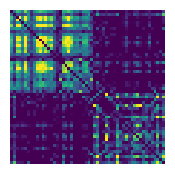

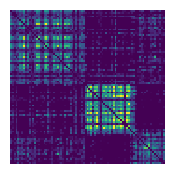

In [6]:


def plot_affinity_session(session_name, figsize_corr=(2, 2)):
    # load
    ensembles = (
        load_derived_generic("ensembles/spont - ensembles - true.csv")
        .query("session_name == @session_name")
        .sort_values("neuron_id")
    )
    labels = ensembles["ensemble_id"].values

    # preprocess
    df_affinity = get_affinity(session_name)
    df_affinity = reorder_df_affinity(df_affinity, labels)

    # plot
    f_corr = plt.figure(figsize=(figsize_corr))
    ax_corr = f_corr.subplots()
    plot_affinity(df_affinity, ax=ax_corr, vmax=0.7, cbar=False)
    ax_corr.axis("off")
    return f_corr


f_sal = plot_affinity_session("hamilton_19")
f_cit = plot_affinity_session("hamilton_23")

f_sal.savefig(fig_dir / "example ensemble matrix sal.png", dpi=300, bbox_inches="tight")
f_cit.savefig(fig_dir / "example ensemble matrix cit.png", dpi=300, bbox_inches="tight")